The objective of this software is to detect road lanes and traffic signs from images (frames of videos) taken from cameras installed in vehicles for applications like autonomous driving or driving assistance.

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
images_path = './images/'

Before applying any detection algorithm, we should apply some preprocesing techniques like smothing or histogram equalization in order to improve the images quality. We are going to use the median filter since it works well with different types of noise and has a low computational cost compared to other techniques like image averaging. 

### **<span style="color:blue"><b><i>Image preprocessing</i></b></span>**

In [3]:
def lut_chart(image, lut):
    """ Applies a LUT to an image and shows the result. 
    
        Args:
            image: Input image to be modified.
            lut: a 256 elements array representing a LUT, where 
                indices index input values, and their content the
                output ones.        
    """   
    # Apply LUT
    im_lut = cv2.LUT(image, lut)
    
    # Show the initial image
    plt.figure(1)
    plt.figure(figsize=(10,10))    
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show the resultant one
    plt.subplot(2, 2, 2)
    plt.imshow(im_lut, cmap='gray')
    plt.title('LUT applied')
    
    # Plot the used LUT
    plt.subplot(2, 2, 3)
    plt.title('LUT')
    plt.plot(np.arange(256), lut) # Hint: np.arange() can be useful as first argument to this function

    # And finally, the resultant histogram
    plt.subplot(2, 2, 4)
    plt.hist(im_lut.ravel(),256,[0,256])
    plt.title('Histogram')
    plt.show()

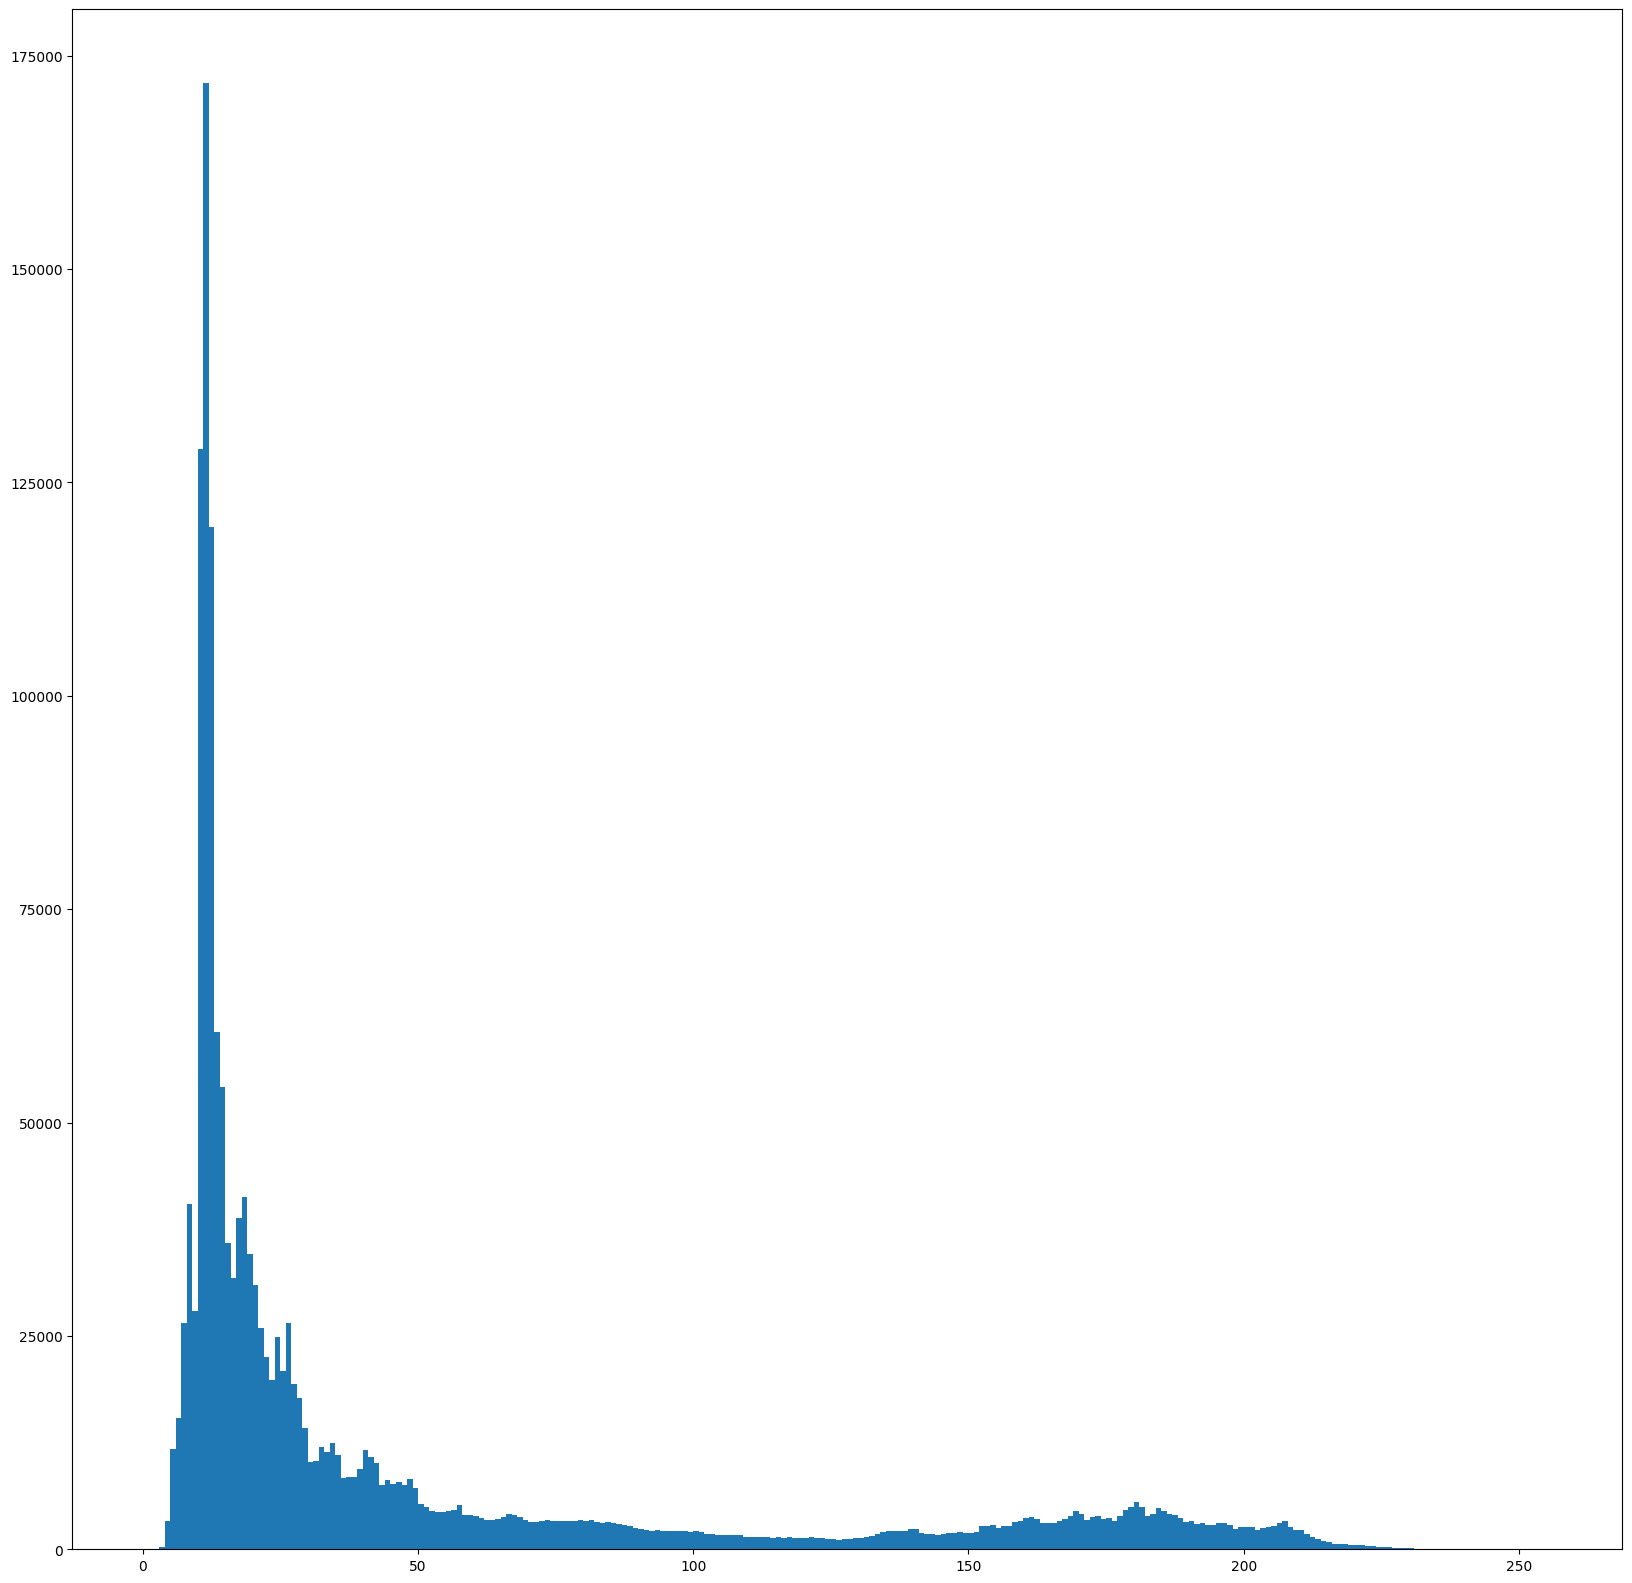

In [4]:
normal = cv2.imread(images_path + 'normal.png', -1)
shadow = cv2.imread(images_path + 'shadow.png', -1)

hist1 = cv2.cvtColor(normal, cv2.COLOR_BGR2GRAY)
normal = cv2.cvtColor(normal, cv2.COLOR_BGR2RGB)
# plt.subplot(2,2,1)
# plt.imshow(normal)

hist2 = cv2.cvtColor(shadow, cv2.COLOR_BGR2GRAY)


# plt.subplot(2,2,3)
# plt.title("Histogram1")
# plt.hist(hist1.ravel(),256,[0,256])


histogram = plt.hist(hist2.ravel(),256,[0,256])

count = 0

for i in range (156):
    pixel_value = histogram[1][100+i]
    frequency = histogram[0][100+i]
    if frequency > 8000:
        count += 1
    # print(f"Pixel Value: {pixel_value}, Frequency: {frequency}")

if count >= 5:
    shadow = cv2.cvtColor(shadow, cv2.COLOR_RGB2GRAY)
    lut = np.arange(256)
    a = 50
    b = -2.5
    lut = np.clip((lut-a)*b, 0, 255)

    lut_chart(shadow,lut)

# plt.subplot(2,2,4)
# plt.title("Histogram2")
# plt.hist(hist2.ravel(),256,[0,256]) # ravel() returns a 1-D array, containing the elements of image
# plt.show()



In [5]:
def lut_chart(image, gamma, verbose=False):
    """ Applies gamma correction to an image and shows the result.   
    
        Args:
            image: Input image
            gamma: Gamma parameter
            verbose: Only show images if this is True
            
        Returns:
            out_image: Gamma image
    """
    
    #Transform image to YCrCb color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    out_image = np.copy(image)
    
    # Define gamma correction LUT
    lut = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply LUT to first band of the YCrCb image
    out_image[:,:,0] = cv2.LUT(out_image[:,:,0], lut)
    
    if verbose:
        # Plot used LUT
        plt.subplot(2, 2, 3)
        plt.title('LUT')
        plt.plot(np.arange(256), lut)

        # Plot histogram of gray image after applying the LUT
        plt.subplot(2, 2, 4)
        plt.hist(out_image[:,:,0].ravel(), 256,[0,256])
        plt.title('Histogram')

        # Reconvert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)
        out_image = cv2.cvtColor(out_image, cv2.COLOR_YCrCb2RGB)

        # Show the initial image
        plt.subplot(2, 2, 1)
        plt.imshow(image)
        plt.title('Original image')

        # Show the resultant one
        plt.subplot(2, 2, 2)
        plt.imshow(out_image)
        plt.title('LUT applied')

        gray = cv2.cvtColor(out_image, cv2.COLOR_RGB2GRAY)
        # ret, gray = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

        # img_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        # binary_img = np.zeros_like(img_lab)
        # binary_img[(img_lab[:, :, 2] < 122) & ((gray > 1)) ] = 255
        
        # plt.subplot(2, 2, 3)
        # plt.imshow(binary_img, cmap = 'gray')
        # plt.title('LUT applied')

        img = cv2.medianBlur(gray,5)
        ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
        th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
        cv2.THRESH_BINARY,11,2)
        th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv2.THRESH_BINARY,11,2)
        titles = ['Original Image', 'Global Thresholding (v = 127)',
        'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
        images = [img, th1, th2, th3]
        for i in range(4):
            plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
            plt.show()
        return out_image

In [6]:
# Create widget object
gamma_widget = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='Gamma:')

#Read image
normal = cv2.imread(images_path + 'normal.png', -1)
shadow = cv2.imread(images_path + 'shadow.png', -1)

#Interact with your code!
interactive(lut_chart, image=fixed(shadow), gamma=gamma_widget, verbose=fixed(True))



interactive(children=(FloatSlider(value=1.0, description='Gamma:', max=5.0, min=0.1), Output()), _dom_classes=…

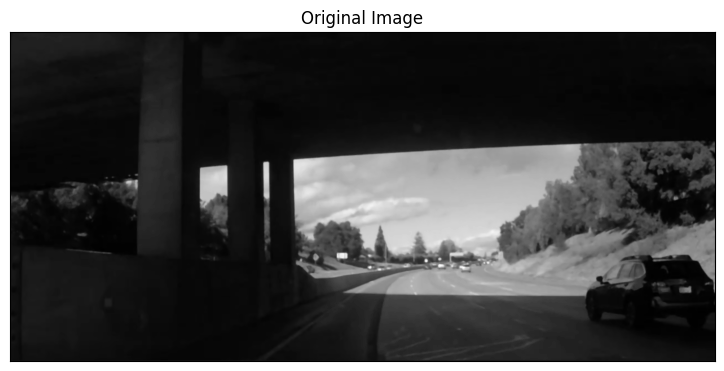

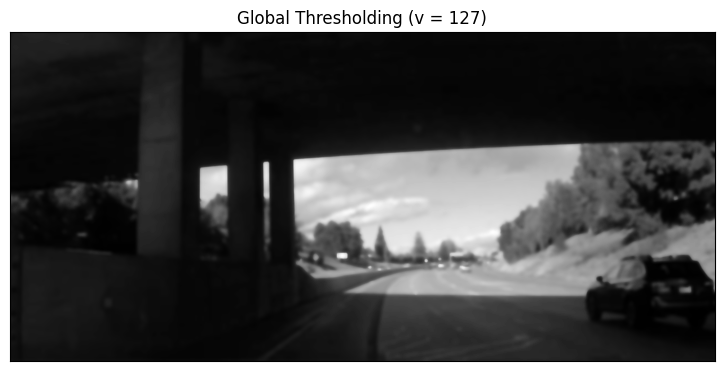

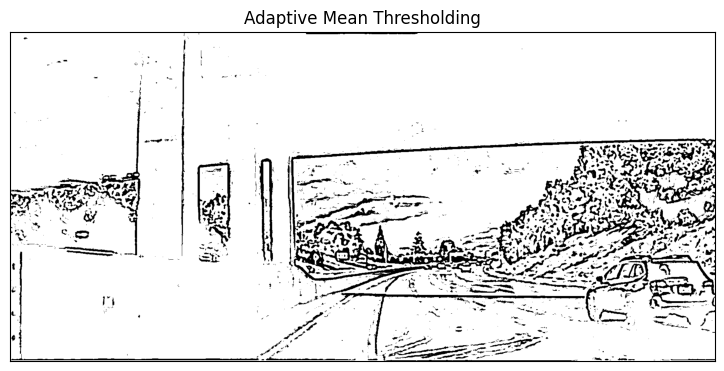

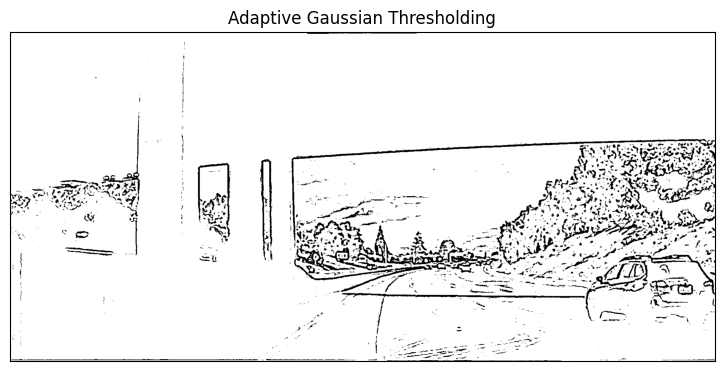

In [7]:
img = cv2.imread(images_path +'shadow.png',-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.medianBlur(img,5)
th1= cv2.bilateralFilter(img, 15, 75, 75) 
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.show()

In [7]:
def laplace_testing(image, size_Laplacian, sigma, w_gaussian):
    """ Apply Laplacian and Log operators to an image.   
    
        Args:
            image: Input image to be binarized
            size_Laplacian: size of Laplacian kernel (odd)
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """  
    # Write your code here!
    
    # Blur image
    #blurred_img = gaussian_smoothing(image, sigma, w_gaussian)
    
    # Apply Laplacian to the original image
    laplacian = cv2.Laplacian(image, cv2.CV_8U, ksize=size_Laplacian)
    
    # Aplay Laplacian to the blurred image
    #laplacian_blurred = cv2.Laplacian(blurred_img, cv2.CV_8U, ksize=size_Laplacian)
    
    # Show initial image
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show laplacian
    plt.subplot(132)
    plt.imshow(laplacian, cmap='gray')
    plt.title('Laplacian without blurring')
    
    # # Show LoG
    # plt.subplot(133)
    # plt.imshow(laplacian_blurred, cmap='gray')
    # plt.title('Laplacian blurred (LoG)')

In [8]:
img = cv2.imread(images_path +'shadow.png',-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Interact with the parameters!
laplace_testing(image=fixed(img), size_Laplacian=(1,7,2), sigma=(1,3,0.1), w_gaussian=(1,3,1));

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'Laplacian'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
def median_filter(image, window_aperture):
    """ Applies median filter to an image and display it.   
        Args:
            image: Input image
            w_window: window aperture size
            verbose: Only show images if this is True
        Returns:
            smoothed_img: smoothed image 
    """
    smoothed_image = np.copy(image)
    smoothed_image = cv2.medianBlur(image, window_aperture * 2 + 1)   
    return smoothed_image

def equalize_chart(image):
    """ Applies histogram equalization to an image and shows the result.   
        Args:
            image: Input image
            verbose: Only show images if this is True 
        Returns:
            out_image: Equalized histogram image
    """
    #Transform image to YCrCb color space
    out_image = np.copy(image)
    out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2YCrCb)
    
    # Apply histogram equalization to first band of the YCrCb image
    out_image[:,:,0] = cv2.equalizeHist(out_image[:,:,0])

    # Reconvert image to RGB
    out_image = cv2.cvtColor(out_image, cv2.COLOR_YCrCb2RGB)

    return out_image

In [3]:
def binarize(img):
    #SEPARATE FUNCTION
    binary = cv2.convertScaleAbs(img, alpha=1.1, beta=-90)
    binary = cv2.cvtColor(binary, cv2.COLOR_RGB2HSV)
    binary[:, :, 1] = np.zeros_like(binary[:, :, 1])
    binary = cv2.cvtColor(binary, cv2.COLOR_HSV2RGB)

    ret, binary = cv2.threshold(binary[:,:,0], int(cv2.mean(binary[:,:,0])[0])+45, 255, cv2.THRESH_BINARY)

    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    binary_img = np.zeros_like(binary)
    binary_img[(img_lab[:, :, 2] < 115) | (binary > 1) ] = 255


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 7))
    black = cv2.morphologyEx(img_lab[:, :, 0], cv2.MORPH_TOPHAT, kernel)
    lanes = cv2.morphologyEx(img_hls[:, :, 1], cv2.MORPH_TOPHAT, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    yellow = cv2.morphologyEx(binary_img, cv2.MORPH_TOPHAT, kernel)

    #lanes = np.zeros_like(lanes)
    #black = np.zeros_like(black)
    #yellow = np.zeros_like(yellow)
    final_mask = np.zeros_like(binary)
    final_mask[(yellow > 1) | (lanes > 2) | (black > 3)] = 255

    small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 7))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_ERODE, small_kernel, 10)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_ERODE, small_kernel, 10)
    small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_ERODE, small_kernel, 10)


    small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 31))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_DILATE, small_kernel)

    return final_mask

In [32]:
def getStartingPoints(line_mask):
    #line_mask = PreProcessing.binarize(line_mask)
    graph = np.sum(line_mask[3 * (line_mask.shape[0] // 4):, :], axis=0)
    midpoint = int(graph.shape[0] / 2)

    left_starting_point = np.argmax(graph[:midpoint])
    right_starting_point = midpoint + np.argmax(graph[midpoint:])

    return left_starting_point, right_starting_point

### **<span style="color:blue"><b><i>Transform to topview</i></b></span>**

[280, 665]
[300, 470]
[980, 470]
[1000, 665]
960
1405


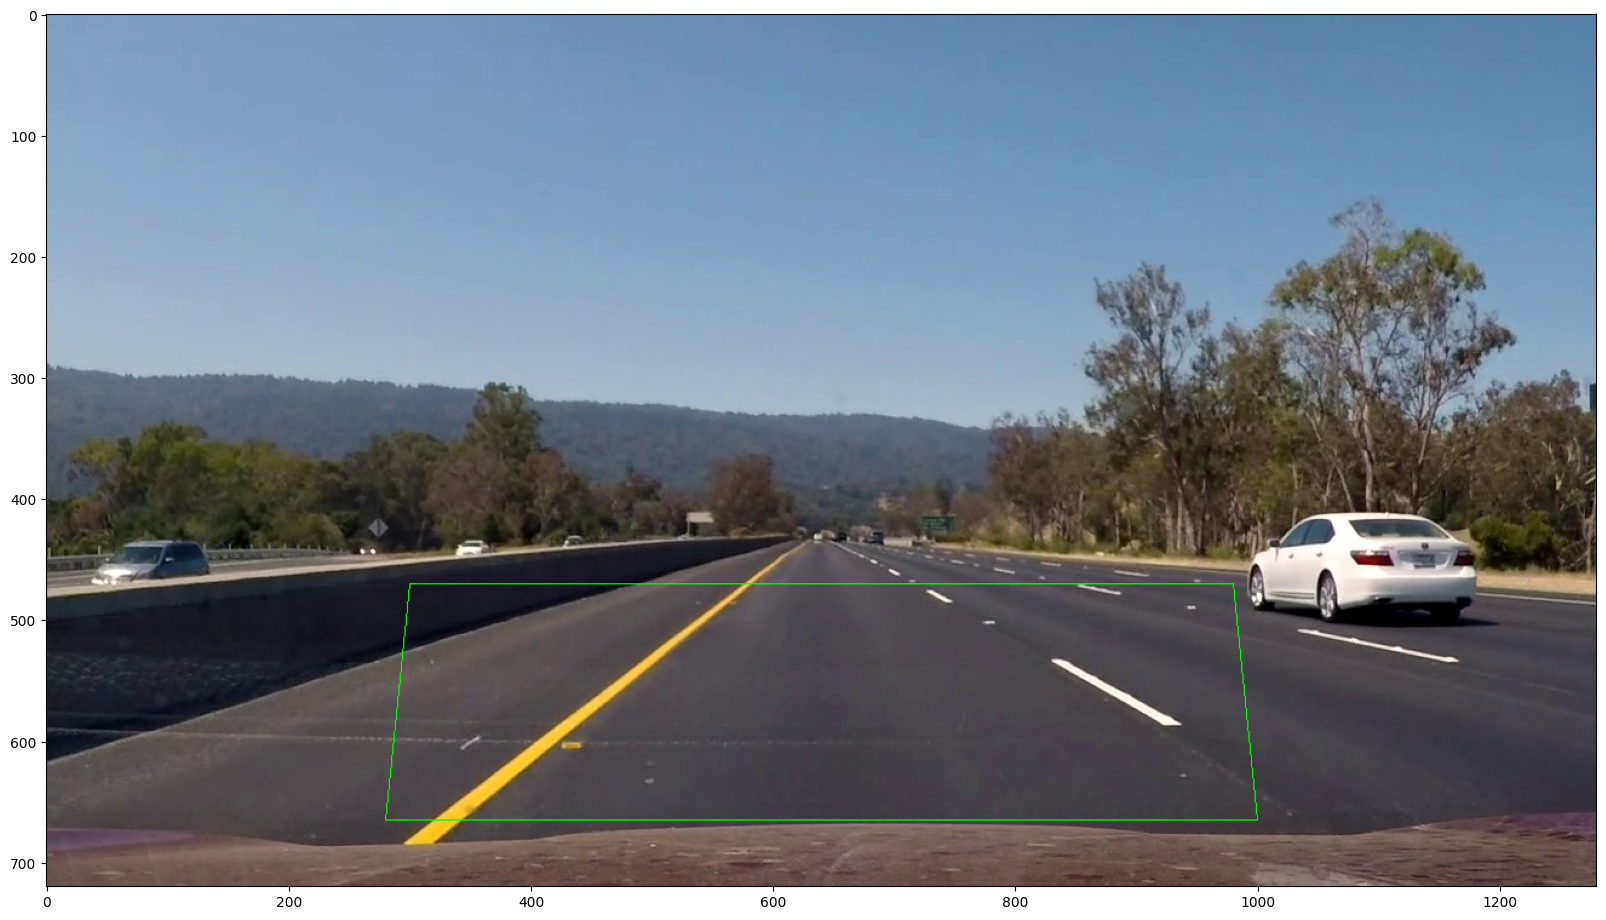

In [48]:
image = cv2.imread(images_path + 'frame_335.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

IMAGE_H = 720
IMAGE_W = 1280

pts_src = np.array([[280, IMAGE_H - 55],  ##bottom left
                        [1000, IMAGE_H - 55],  # bottom rigt
                        [300, 470],  # top left
                        [IMAGE_W - 300, 470]])  # top right

pts_dst = np.array([[530, IMAGE_H], [760, IMAGE_H], [0, 0], [IMAGE_W, 0]])

# Calculate Homography
M, status = cv2.findHomography(pts_src, pts_dst)
Minv, status = cv2.findHomography(pts_dst, pts_src)

print([280, IMAGE_H - 55])
print([300, 470])
print([IMAGE_W - 300, 470])
print([1000, IMAGE_H - 55])

pts = np.array([[280, IMAGE_H - 55],[300, 470],  [IMAGE_W - 300, 470], [1000, IMAGE_H - 55]])  # top right
pts = pts.reshape((-1,1,2))

pts2 = np.array([[760, IMAGE_H], [530, IMAGE_H], [0, 0], [IMAGE_W, 0]])
pts2 = pts2.reshape((-1,1,2))


# Warp source image to destination based on homography

#image = cv2.warpPerspective(image, M, (1280,720))
#no_perspective = cv2.warpPerspective(no_perspective, Minv, (1289,720))

cv2.polylines(image, [pts], True, (0, 255, 0))

image2 = np.copy(image)

#image = binarize(image)

#ret, image = cv2.threshold(image, int(cv2.mean(image)[0])+45, 255, cv2.THRESH_BINARY)
l, r = getStartingPoints(image)
print(l)
print(r)

# cv2.line(image2, (l, 0), (l, 720), thickness = 5 , color = [0, 0, 255])
# cv2.line(image2, (r, 0), (r, 720), thickness = 5 , color = [0, 0, 255])


plt.imshow(image)
#plt.imshow(no_perspective)

im_out = cv2.cvtColor(image2,cv2.COLOR_RGB2BGR)
cv2.imwrite(images_path + "pre_perspective_transform.jpg",im_out);


# 

In [16]:
def pixels_in_window(window_center, margin, window_height):
        topleft = (window_center[0]-margin, window_center[1]-window_height//2)
        bottomright = (window_center[0]+margin, window_center[1]+window_height//2)

        condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
        condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
        return nonzerox[condx&condy], nonzeroy[condx&condy]

717.0
(718, 1282)


Text(0.5, 1.0, 'Equalized histogram image')

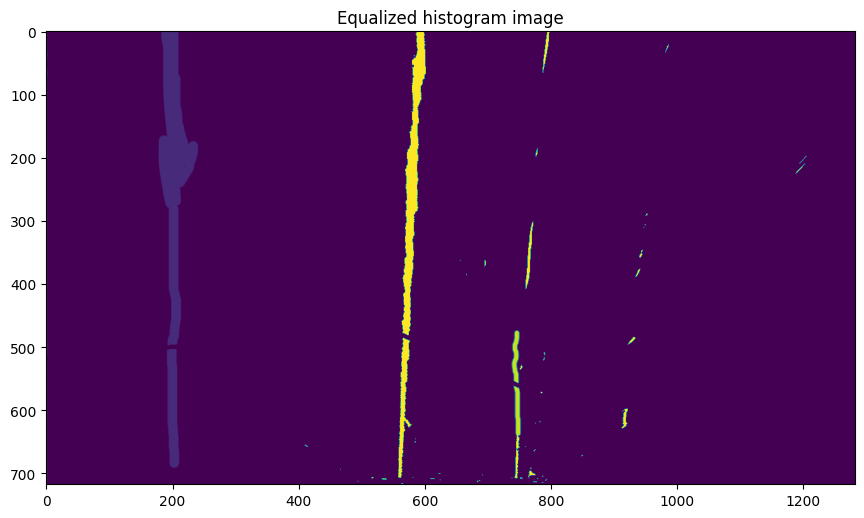

In [18]:
nwindows = 9
margin = 100
minpix = 10

topview_binary = out

window_height = int(topview_binary.shape[0]//nwindows)

# Identify the x and y positions of all nonzero pixel in the image
nonzero = topview_binary.nonzero()
nonzerox = np.array(nonzero[1])
nonzeroy = np.array(nonzero[0])


bottom_half = topview_binary[topview_binary.shape[0]//2:,:]
histogram = np.sum(bottom_half, axis=0)


midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Current position to be update later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base
y_current = topview_binary.shape[0] + window_height//2

leftx, lefty, rightx, righty = [],[],[],[]

for i in range (nwindows):
    y_current -= window_height
    center_left = (leftx_current, y_current)
    center_right = (rightx_current, y_current)

    pixels_left_x, pixels_left_y = pixels_in_window(center_left, margin, window_height)
    pixels_right_x, pixels_right_y = pixels_in_window(center_right, margin, window_height)

    # Append these indices to the lists
    leftx.extend(pixels_left_x)
    lefty.extend(pixels_left_y)
    rightx.extend(pixels_right_x)
    righty.extend(pixels_right_y)

    # Reubicamos la ventana donde se encuentre el centro de la linea
    if len(pixels_left_x) > minpix:
        leftx_current = np.int32(np.mean(pixels_left_x))
    if len(pixels_right_x) > minpix:
        rightx_current = np.int32(np.mean(pixels_right_x))


leftfit = np.polyfit(leftx, lefty, 2)
rightfit = np.polyfit(rightx, righty, 2)

# r1 = (np.max(rightx), np.max(righty))
r1 = np.array([[[int(np.max(rightx)), int(np.max(righty))]]], dtype = "float32")
r2 = np.array([[[int(np.min(rightx)), int(np.min(righty))]]], dtype = "float32")
l1 = np.array([[[int(np.min(leftx)), int(np.max(lefty))]]], dtype = "float32")
l2 = np.array([[[int(np.max(leftx)),int(np.min(lefty))]]], dtype = "float32")
print(r1[0][0][1])
r1 = cv2.perspectiveTransform(r1, M_inv)
r2 = cv2.perspectiveTransform(r2, M_inv)
l1 = cv2.perspectiveTransform(l1, M_inv)
l2 = cv2.perspectiveTransform(l2, M_inv)
# r2 = (np.min(rightx), np.min(righty))
# l1 = (np.min(leftx), np.max(lefty))
# l2 = (np.max(leftx), np.min(lefty))
cv2.line(image, (int(r1[0][0][0]), int(r1[0][0][1])), (int(r2[0][0][0]), int(r2[0][0][1])) , (0,255,255), 5)
cv2.line(image, (int(l1[0][0][0]), int(l1[0][0][1])), (int(l2[0][0][0]), int(l2[0][0][1])), (0,255,255), 5)

#topview = cv2.warpPerspective(topview, M_inv, (1242, 375), flags=cv2.INTER_LINEAR)
# topview = cv2.addWeighted(topview, 1, image, 0.5, 2)
print(np.shape(image))

# result = np.copy(image)
# topview = topview[190:360,350:800]
# result[160:360, 350:800] = topview[160:360, 350:800,:3]

# ([(550, 190),     # top-left
#                 (350, 360),     # bottom-left
#                 (800, 360),    # bottom-right
#                 (650, 190)])

plt.subplot(3, 1, 2)
plt.imshow(image)
plt.title('Equalized histogram image')

### **<span style="color:blue"><b><i>Test</i></b></span>**

In [29]:
def findLane(lane_image, starting_point):
    nwindows = 10
    window_height = int(lane_image.shape[0]/nwindows)
    window_width = 160
    minpixel = 40

    nonzero = lane_image.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    window_pos = starting_point

    lane_pixels = []

    for window in range (nwindows):
        print(window)
        print("------------------------------------------")
        win_top = lane_image.shape[0] - (window*window_height)
        win_bottom = lane_image.shape[0] - ((window+1)*window_height)
        win_left = starting_point - (window_width/2)
        win_right = starting_point + (window_width/2)

        window_pixels = ((nonzeroy >= win_bottom) & (nonzeroy < win_top) & (nonzerox >= win_left) & (nonzerox <= win_right)).nonzero()[0]

        print(window_pixels)
        print("------------------------------------------")

        lane_pixels.append(window_pixels)

        if len(window_pixels) > minpixel:
            window_pos = int(np.mean(nonzerox[window_pixels]))

    lane_pixels = np.concatenate(lane_pixels)

    lane_pixels_x = nonzerox[lane_pixels]
    lane_pixels_y = nonzeroy[lane_pixels]

    #cv2.line(lane_image, (np.max(lane_pixels_x), np.max(lane_pixels_y)), (np.max(lane_pixels_x), np.min(lane_pixels_y)), (255,0,0), 3, cv2.LINE_AA)
    plt.imshow(lane_image)
    lane_fit = None

    if len(lane_pixels_x) != 0:
        lane_fit = np.polyfit(lane_pixels_y, lane_pixels_x, 2)  

    print(lane_fit)

    ploty = np.linspace(0, lane_image.shape[0]-1, lane_image.shape[0] )
    left_fit = lane_fit[0]*ploty**2 + lane_fit[1]*ploty + lane_fit[2]
    plt.plot(left_fit, ploty, color='yellow')

    return lane_fit

0
------------------------------------------
[ 915412  915413  915414 ... 1010107 1010108 1010109]
------------------------------------------
1
------------------------------------------
[816107 816108 816109 ... 914219 914220 914221]
------------------------------------------
2
------------------------------------------
[716727 716728 716729 ... 814896 814897 814898]
------------------------------------------
3
------------------------------------------
[618262 618263 618264 ... 715516 715517 715518]
------------------------------------------
4
------------------------------------------
[519893 519894 519895 ... 617081 617082 617083]
------------------------------------------
5
------------------------------------------
[421320 421321 421322 ... 518700 518701 518702]
------------------------------------------
6
------------------------------------------
[319306 319307 319308 ... 420133 420134 420135]
------------------------------------------
7
----------------------------------------

array([ 1.81255657e-06, -1.33481804e-02,  5.59394343e+02])

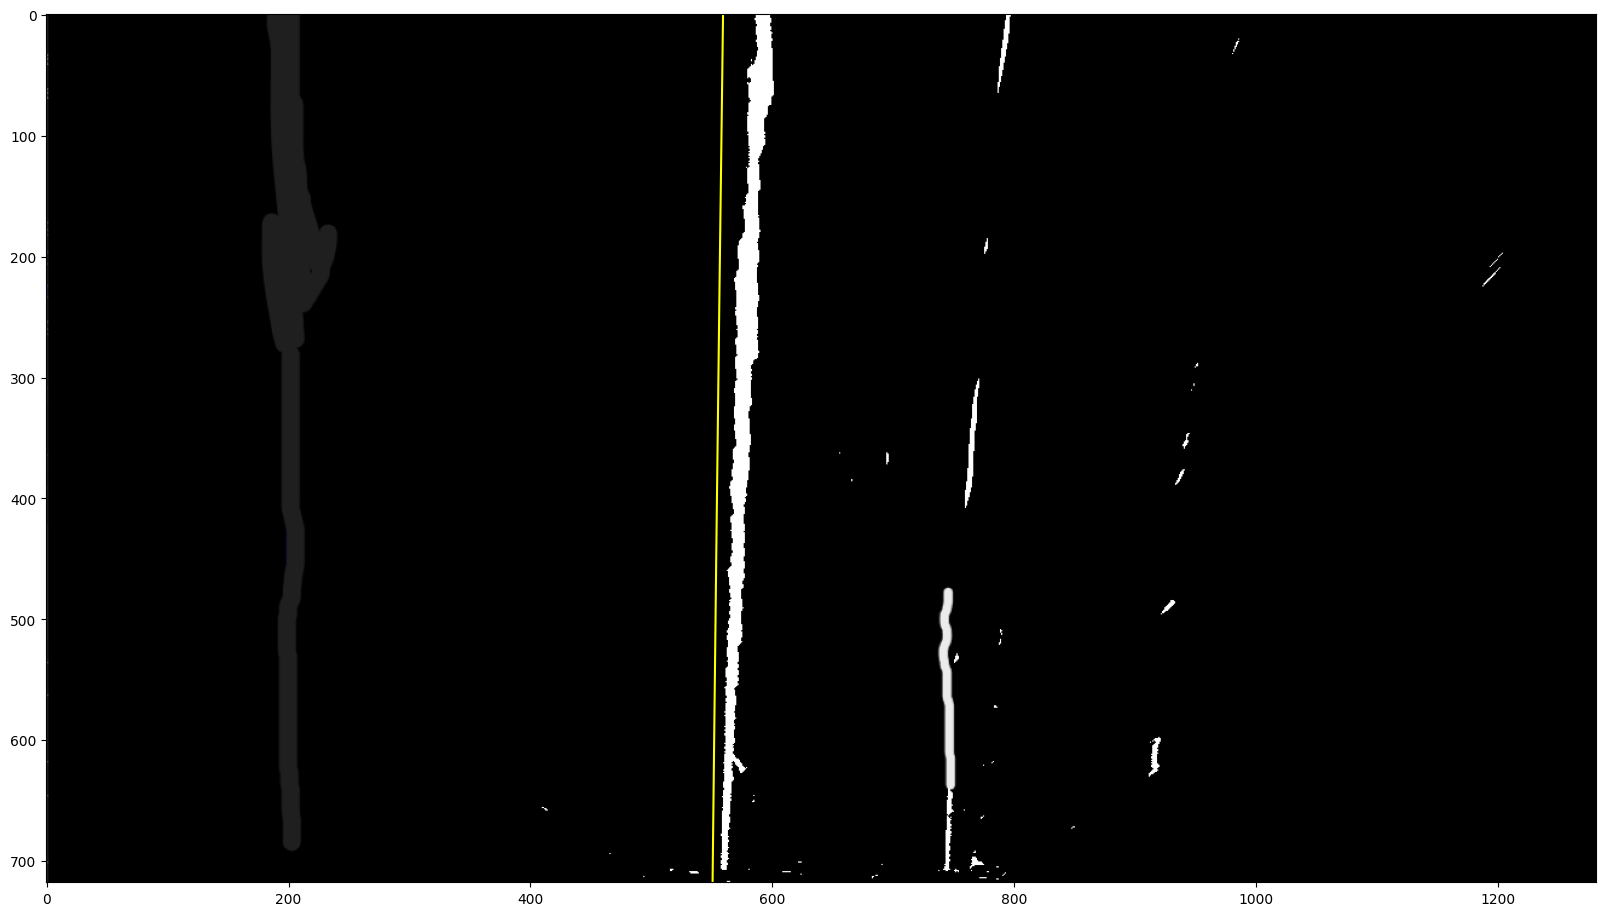

In [30]:
image = cv2.imread(images_path + 'binary.png',-1)

findLane(image, 550)


In [ ]:
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            smoothed_norm: Blurred image
    """   
    # Write your code here!
    
    # Define 1D kernel
    s=sigma
    w=w_kernel
    kernel_1D = np.array([gaussian_bell(x, s) for x in range(-w,w+1)])
    
    # Apply distributive property of convolution
    vertical_kernel = kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)   
    
    # Blur image
    smoothed_img = cv2.filter2D(image, cv2.CV_8U, gaussian_kernel_2D)
    
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img, None, 0, 255, cv2.NORM_MINMAX) # Leave the second argument as None
    
    return smoothed_norm

def gaussian_bell(x, sigma):
    result = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*(sigma**2)))
    return result

In [ ]:
def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    """ Apply Canny algorithm to an image.   
    
        Args:
            image: Input image to be binarized
            lower_threshold: bottom value for hysteresis
            upper_threshold: top value for hysteresis
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """  
    
    # Smooth image
    blurred_img = gaussian_smoothing(image,sigma,w_gaussian)
    
    # Apply Canny to blurred image
    canny_blurred = cv2.Canny(blurred_img,lower_threshold,upper_threshold)

    # Show initial image
    plt.subplot(211)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show Canny with blurring
    plt.subplot(212)
    plt.imshow(canny_blurred, cmap='gray')
    plt.title('Canny smoothed')

In [ ]:
interact(canny_testing, image=fixed(image), lower_threshold=(0,260,20), upper_threshold=(0,260,20), sigma=(1,3,0.1), w_gaussian=(1,3,1));